In [1]:
import os
import gc
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from transfer_learning import TransferLearning

In [2]:
L = 10
bond = 10
path = f"./dataset_L={L}_bond={bond}"
os.makedirs(path, exist_ok=True)
TF = TransferLearning(L = L, bond = bond)

In [3]:
ANNNI_training = TF.generate_ANNNI() #lst_contract, lst_y, lst_kh, lst_dmrg
file_path_train_DMRG = os.path.join(path, 'ANNNI_training.pkl')
with open(file_path_train_DMRG, "wb") as f:
    pickle.dump(ANNNI_training, f)
gc.collect(2)

Generating ANNNI set: 0it [00:00, ?it/s]

Generating ANNNI set: 400it [00:19, 20.60it/s]


0

In [4]:
Ising_dataset = TF.generate_Ising()
file_path_test_DMRG = os.path.join(path, 'Ising_dataset.pkl')
with open(file_path_test_DMRG, "wb") as f:
    pickle.dump(Ising_dataset, f)
gc.collect(2)

Generating Ising set: 100%|██████████| 400/400 [00:13<00:00, 29.10it/s]


26

In [5]:
file_path_train_DMRG = os.path.join(path, 'ANNNI_training.pkl')
with open(file_path_train_DMRG, 'rb') as f:
    ANNNI_training = pickle.load(f)
file_path_test_DMRG = os.path.join(path, 'Ising_dataset.pkl')
with open(file_path_test_DMRG, 'rb') as f:
    Ising_dataset = pickle.load(f)

In [6]:
gram_train = TF.get_kernel_train(ANNNI_training)

file_path_kernel_train_DMRG= os.path.join(path, "kernel_train_ANNNI.hdf5")
with h5py.File(file_path_kernel_train_DMRG, "w") as f:
    f.create_dataset(" gram_train_DMRG", data = gram_train)
    
gc.collect(2)

Computing Gram matrix for training set...


Gram Train: 100%|██████████| 364816/364816 [02:37<00:00, 2315.73it/s] 


Gram matrix for training set computed in 157.54 seconds.


0

In [6]:
gram_test = TF.get_kernel_test(trainset=ANNNI_training, testset=Ising_dataset)

file_path_kernel_test_DMRG= os.path.join(path, "kernel_test_Ising.hdf5")
with h5py.File(file_path_kernel_test_DMRG, "w") as f:
    f.create_dataset("gram_test_Ising", data = gram_test)

gc.collect(2)

Computing Gram matrix for test set...


Gram Test: 100%|██████████| 400/400 [03:18<00:00,  2.01it/s]


Gram matrix for testing set computed in 198.68 seconds.


0

In [8]:
file_path_kernel_train_DMRG= os.path.join(path, "kernel_train_ANNNI.hdf5")
with h5py.File(file_path_kernel_train_DMRG, "r") as f:
    gram_train = f[" gram_train_DMRG"][:] 
file_path_kernel_test_DMRG= os.path.join(path, "kernel_test_Ising.hdf5")
with h5py.File(file_path_kernel_test_DMRG, "r") as f:
    gram_test = f["gram_test_Ising"][:] 

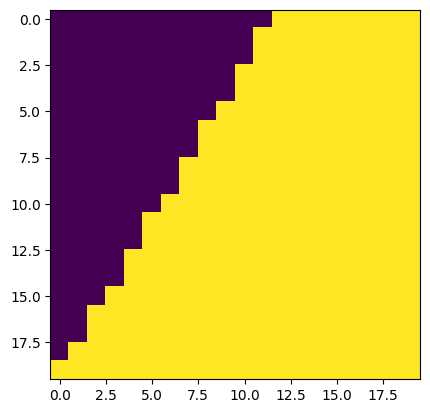

In [9]:
clf = svm.SVC(kernel='precomputed')
y = ANNNI_training[1]
clf.fit(gram_train, y) 
y_pred = clf.predict(gram_test)
plt.imshow(np.rot90(y_pred.reshape(20,20)))
plt.savefig(f'result for DMRG states with L={L} and bond dimension ={bond}.png')
plt.show()

In [10]:
def generate_dataset(k=None, h=None):
    if k is None and h is None:
        # Generate the dataset for the whole range
        k_value = np.linspace((1e-5), 1, 20)
        h_value = np.linspace((1e-5), 2, 20)
        lst = []
        for kv in k_value:
            for hv in h_value:
                lst.append(kv)
                lst.append(hv)
    elif h is None:
        # Generate the dataset for the specified constant k
        h_value = np.linspace((1e-5), 2, 10)
        lst = []
        for hv in h_value:
            lst.append(k)
            lst.append(hv)
    elif k is None:
        # Generate the dataset for the specified constant h
        k_value = np.linspace((1e-5), 1, 20)
        lst = []
        for kv in k_value:
            lst.append(kv)
            lst.append(h)
    else:
        # Generate the dataset for the boundary values
        k_value = np.linspace((1e-5), 1, 10)
        h_value = np.linspace((1e-5), 2,10)
        lst = []
        for hv in h_value:
            lst.append(k)
            lst.append(hv)
        for kv in k_value:
            lst.append(kv)
            lst.append(h)

    # Generate final dataset which is based on (k, h) format
    result = np.array(lst).reshape(int(len(lst)/2), 2)

    # making functions for determining the target part of data
    def hI_k(x):
        return (((1 - x) / x) * (1 - np.sqrt((1 - (3 * x) + (4 * (x ** 2))) / (1 - x))))        
    def hC_k(x):
        return (1.05 * (np.sqrt(np.abs((x - 0.5) * (x - 0.1)))))
    
    # making the feature part of the data
    lst_x = []
    lst_y = []

    lst_label = []

    for element in result:
        k = element[0]
        h = element[1]

        # the target part
        # y = np.where(k < 0.5, np.where(h < hI_k(k), -1, 0), np.where(h < hC_k(k), 1, 0))
        if k < 0.5:
            if h < hI_k(k):
                y = -1
            else:
                y = 0
        elif k > 0.5:
            if h < hC_k(k):
                y = 1
            else:
                y = 0
            
        lst_label.append(y)
        lst_x.append(k)
        lst_y.append(h)



    return lst_x, lst_y, lst_label
    



In [11]:
lst_x, lst_y, lst_y_before = generate_dataset(k=None, h=None)

In [16]:
import pandas as pd
ANNNI_dataset = pd.DataFrame({'x': lst_x, 'y': lst_y, 'label': lst_y_before})
ANNNI_dataset.to_csv('dataset_ANNNI.csv', index=False)


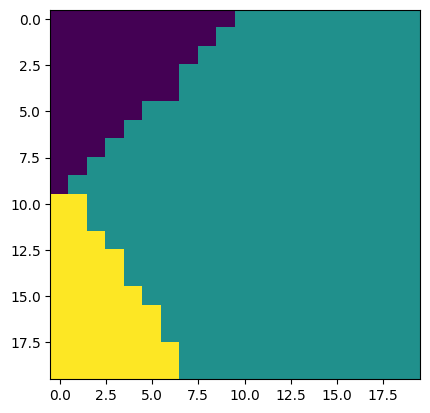

In [22]:
plt.imshow(np.array(ANNNI_dataset['label']).reshape(20,20))